In [1]:
from IPython.display import Math


# Residual Neural Networks - a comprehensive overview

## Introduction

Residual neural networks are quite easy to comprehend when you understand the basics of neural networks. Ordinarily, neural networks consist of multiple neurons passing their outputs to one another. With residual neural networks (ResNet) you don’t just pass the output of the previous neuron to the next, but you also carry over the input from the previous neuron. This process looks something like this.

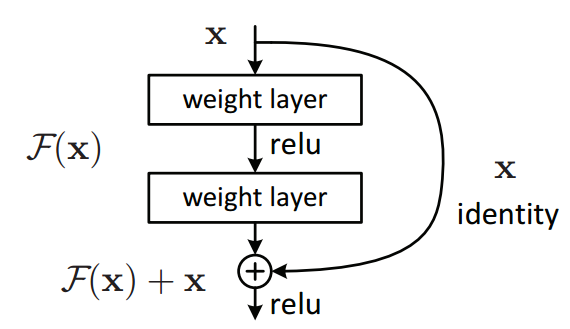
<i><center>[1] Image representing a residual/identity block (source: https://en.wikipedia.org/wiki/Residual_neural_network)</center></i>

Residual Neural Networks or ResNets often implement double- or triple- layer skips that contain nonlinearities (ReLu) and batch normalization in between. ResNets builds on what we call pyramidal cells in the cerebral cortex.

## Pyramidal Cells

Pyramidal cells are important for the cognitive ability. The degree of complexity of the pyramidal neurons is likely linked to the cognetive capabilities of different anthropoid species. Pyramidal cells play a critical role in complex object recognition within the visual processing areas of the cortex. What this tells us is that the architecture of this important cell can help us develop an algorthim that will preform well on predictions - especially object recognition it seems. This is great, but why do neurons in the ResNet take the output and input of the previous neuron?

![220px-Piramidal_cell.svg.png](attachment:220px-Piramidal_cell.svg.png)

<i><center>[2] Image representing a reconstruction of a pyramidal cell (source: https://en.wikipedia.org/wiki/Pyramidal_cell)</center></i>

The awnser lies within this image. As you can see the apical dendrite (3) skips multiple layers, while the basal dendrite (2) collects signals from the previous and/or same layer. We can also find similar structures for other layers. It is also important to acknowledge the fact that it is not clear how many layers in the cerebral cortex that compare to the layers in a artificial neural network, nor wether or not every area in the cerebrel cortex has the same structure, but over large areas
they appear similar.
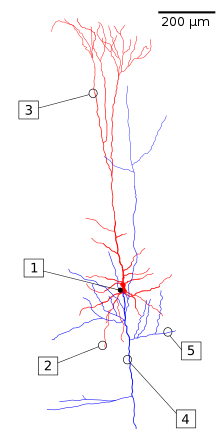

In [5]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

## ResNet Implementation

In this implementation I am showcasing how you can setup your ResNet for image classification.

### Residual Block

In [7]:
def residual_block(X, f, filters, stage, block):
    # Retrieve filters
    F1, F2, F3 = filters
    
    # Input value
    X_in = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_in])
    X = Activation('relu')(X)
    
    return X

At the end we add the given output and the inital input (X_in).

### Convolutional Block

In [8]:
def convolutional_block(X, f, filters, stage, block, s=2):
    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_in = X

    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_in])
    X = Activation('relu')(X)

    return X

### ResNet model

In [9]:

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

As you can see the implementation is very straight forward once you understand the background of the model.

# Credits

Wikipedia. Pyramidal cell. https://en.wikipedia.org/wiki/Pyramidal_cell. Downloaded 8 June 2019.

Wikipedia. Residual neural networks. https://en.wikipedia.org/wiki/Residual_neural_network. Downloaded 8 June 2019.

Peixerio, Marco. Hitchhiker's Guide to Residual Networks (ResNet) in Keras. https://towardsdatascience.com/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff. Downloaded 8 June 2019.

Marco Peixerio. Github. https://github.com/marcopeix/Deep_Learning_AI/blob/master/4.Convolutional%20Neural%20Networks/2.Deep%20Convolutional%20Models/resnets_utils.py. 8 June 2019.

Keras Documentation. Convolutional Layers. https://keras.io/layers/convolutional/. Downloaded 8 June 2019.

Kaiming He, Xiangyu Zhang, Shaoqing, Jian Sun. Deep Residual Learning for Image Recognition. https://arxiv.org/abs/1512.03385. Downloaded 8 June 2019.